# Tutorial 2.1: $V_{phys}$ Parametrization

In this section, we show how the $V_{phys}$ part of MB-nrg PEFs are parametrized. $V_{phys}$ is the underlying "physically-inspired" baseline consisting of dispersion and electrostatics interactions upon which the many-body polynomials are applied as "corrections". As a reminder, $V_{phys}$ has the form:

#### <center> $V_{phys} = V_{disp} + V_{elec}$ </center>

Here, $V_{disp}$ is the disperison energy and $V_{elec}$ is the electrostatics energy. $V_{disp}$ has the form:

#### <center> $V_{disp} = ...$ </center>

where, $R_{ij}$, $C^6_{ij}$, and $d^6_{ij}$ are the distance between atoms, dispersion coefficient, and damping parameter for atom pair $i$, $j$. $damp(...)$ is the tang-toennies damping function of the form:

#### <center> $damp(...) = ...$ </center>

And $V_{elec}$ has the form:

#### <center> $V_{elec} = ...$ </center>

where $q_i$, $p_i$, $\alpha_i$, and $\mu_i$ are the partial charge, polarizability, polarizability factor, and dipole moment at to site $i$.

Before we can build an MB-nrg PEF for any system, we first need to define the $q_i$, $p_i$, and $\alpha_i$ for each atom type and the $C^6_{ij}$ and $d^6_{ij}$ for each atom type pair.

<b>Note: This notebook describes how modern MB-nrg potentials are parametrized. Some models, such as MB-pol and older MB-nrg models were parametrized before the approach described here was standardized. Consult the publications about those PEFs for more details.</b>

That being said, we have found that MB-nrg PEFs are not too "sensitive" to the exact values of the parameters that enter $V_{phys}$, since the many-body PIPs will correct at short-range, and dispersion and electrostatics fall off *relatively* fast at long range. ("relatively" is doing a lot of work here.)

## 2.1.0 Definitions and Imports

In [80]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1.1 Polarizabilities and Polarizability Factors.

All MB-nrg models set the polarizability factors equal to the polarizabilities and calculate them in the following way:


#### <center> $p_i = \alpha_i = p^{free}_i  \frac{v_i}{v^{free}_i} ^ {4/3}$ </center>

Here, $p^{free}_i$, $v^{free}_i$, and $v_i$ are the free polarizability, free volume, and effective volume for atom $i$. We calculate the free volumes and effective volumes using QChem's implementation of the eXchange-hole Dipole Moment (XDM) model, and the free polarizabilities have been tabulated at the CCSD(T) level.

To run the XDM calculation, do the following:

In [20]:
optimized_structure_CH3NH2 = read_system(monomer_CH3NH2_definition_path, monomer_CH3NH2_minimum_structure_path)

polarizabilities_CH3NH2 = calculate_polarizabilities_by_XDM(
        optimized_structure_CH3NH2,
        f"{logs_dir}",
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(jobs_dir)
)

polarizability_factors_CH3NH2 = polarizabilities_CH3NH2

Beginning XDM calculation...
Completed XDM calculation!


In [22]:
print(polarizabilities_CH3NH2)
print(polarizability_factors_CH3NH2)

{'A': 1.1961690533033624, 'B': 0.3322263799649547, 'C': 0.9504508010167653, 'D': 0.3524497681327246}
{'A': 1.1961690533033624, 'B': 0.3322263799649547, 'C': 0.9504508010167653, 'D': 0.3524497681327246}


Note that in addition to the "E" and "F" atoms (the "O" and "H" on water respectively. We also have "M" here. This corresponds to the M-site in MB-pol water. The polarizability of the M-site is 0, so that it does not have an induced dipole, but the polarizability factor is non-zero so that the charge at the M-site can still have its screening function computed.

In [25]:
polarizabilities_H2O = {
    "E": 1.310,
    "F": 0.294,
    "M": 0.0
}
polarizability_factors_H2O = {
    "E": 1.310,
    "F": 0.294,
    "M": 1.310
}

In [26]:
print(polarizabilities_H2O)
print(polarizability_factors_H2O)

{'E': 1.31, 'F': 0.294, 'M': 0.0}
{'E': 1.31, 'F': 0.294, 'M': 1.31}


## 2.1.x Atomic Radii

In [33]:
optimized_structure_CH3NH2 = read_system(monomer_CH3NH2_definition_path, monomer_CH3NH2_minimum_structure_path)

radii_CH3NH2 = calculate_radii_by_XDM(
        optimized_structure_CH3NH2,
        f"{logs_dir}",
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(jobs_dir)
)

Beginning XDM calculation...
Completed XDM calculation!


In [35]:
radii_CH3NH2

{'A': 1.003204764154268,
 'B': 0.577466204832772,
 'C': 0.9575736540641085,
 'D': 0.5860603657644929}

In [34]:
optimized_structure_H2O = read_system(monomer_H2O_definition_path, monomer_H2O_minimum_structure_path)

radii_H2O = calculate_radii_by_XDM(
        optimized_structure_H2O,
        f"{logs_dir}",
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(jobs_dir)
)

Beginning XDM calculation...
Completed XDM calculation!


In [36]:
radii_H2O

{'E': 0.9183047911211052, 'F': 0.5857168367492249}

## 2.1.2 Atomic Partial Charges.

Previous MB-nrg models have used a variety of methods to calculate the atomic partial charges. MB-pol uses the Partridge-Swenkee (check sp lol) geometry-dependent atomic partial charges. Other models have used either Charge Model 5 (cite) or CHELPG (cite). The most recent generation of models has used charges fit to reproduce a monomer's multipole moments using an approach similar to the Stewart fitting appraoch (cite). However, we have recently developed a new apprach based on CHELPG that we feel provides the most useful model of a monomer's charge for our purposes. 

We will fit the partial charges of methylamine to reproduce the electrostatic potential on a number of grid points. However unlike CHELPG, which uses grid points very close to the monomer's electron density (usually within 4 A of the nucleii), we will fit to points quite far away from the electron density. The justification for this is that since we will have the many-body polynomials to correct at short-range, so it is most important that our electrostatics model reproduces long-range interactions. We will fit to grid points that are between 9 and 11 Å past the edge of the electron density of our monomer.

To do that, run the following:

In [61]:
# calculator = QchemCalculator("wB97M-V", "AUG-cc-pVTZ", log_directory=f"{logs_dir}")
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [78]:
minimized_structure_CH3NH2 = read_system(monomer_CH3NH2_definition_path, monomer_CH3NH2_minimum_structure_path)
vibrational_modes_CH3NH2 = calculate_vibrational_modes(
        minimized_structure_CH3NH2,
        calculator,
        get_qchem_job_manager(jobs_dir),
        restart_dir.file("normal_modes_CH3NH2.restart"),
        16,
        32000
)
write_vibrational_modes(vibrational_modes_CH3NH2_path, vibrational_modes_CH3NH2)

Calculating vibrational modes:  |====================================================================================================| - 1/1
Completed vibrational mode calculations minimizations!


In [113]:
configuration_generator = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        classical=False,
        distribution="constant",
        temperature=1000
)
charge_parametrization_configurations_CH3_NH2 = list(configuration_generator.generate_configurations(num_configs=100, seed=12345))
write_systems(charge_configs_CH3NH2_path, charge_parametrization_configurations_CH3_NH2)

Will generate configurations at temperature 1000 K.
Temp Distribution: temp (au) = 0.00316683 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 100 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 100 configs.


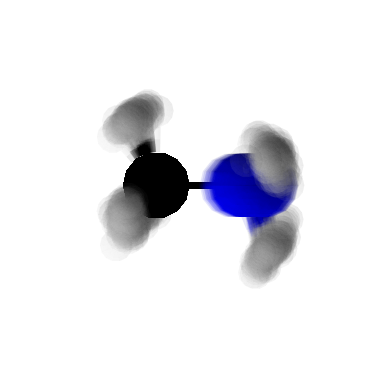

In [114]:
render_overlayed_systems(
    charge_parametrization_configurations_CH3_NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05
)

In [117]:
grid_points, grid_point_weights = get_ESP_grid_points(
        charge_parametrization_configurations_CH3_NH2,
        atomic_radii=radii_CH3NH2,
        grid_radii=[9.0, 10.0, 11.0]
)

In [ ]:
esp_at_grid_points = calculate_ESP_at_grid_points(
    
)

In [ ]:
fit_charges_to_ESP(
        read_definition(monomer_CH3NH2_definition_path),
        read_systems(monomer_CH3NH2_definition_path, charge_parametrization_configurations_CH3_NH2),
        grid_points=...,
        grid_point_weights=...,
        grid_point_reference_values=...,
        formal_charge=0.0,
    
)

## 2.1.3 Dispersion Parameters

Lastly, we will calculate the dispersion coefficients ($C^6_{ij}$) and damping parameters ($d^6_{ij}$). These also both come from XDM, but in different ways. The $C^6$ are directly computed from XDM, by the equation:

#### <center> $C^6_{ij} = ... $ </center>

See QChem's documentation about the XDM module for more info (link).

The damping parameters are chosen so that the dispersion is exactly half on at a distance equal to the sum of the two atom's atomic radii ($r_i + r_j$). This is done by solving the following equation for $d_{ij}$:

#### <center> $ \frac{1}{2} = damp(r_i + r_j, d^6_{ij}) $ </center>

To run the XDM calculation and calculate the dispersion parameters, do the following:

In [41]:
optimized_structure_CH3NH2 = read_system(monomer_CH3NH2_definition_path, monomer_CH3NH2_minimum_structure_path)
optimized_structure_H2O = read_system(monomer_H2O_definition_path, monomer_H2O_minimum_structure_path)

C6 = calculate_C6_by_XDM(
        optimized_structure_CH3NH2,
        optimized_structure_H2O,
        f"{logs_dir}",
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(jobs_dir)
)

Beginning XDM calculation...
Completed XDM calculation!


In [45]:
C6

{('A', 'E'): 215.64600938969002,
 ('A', 'F'): 103.08292627758921,
 ('B', 'E'): 81.55966323179395,
 ('B', 'F'): 37.42916571920306,
 ('C', 'E'): 200.9159401221131,
 ('C', 'F'): 92.45908773193739,
 ('D', 'E'): 82.35197285095734,
 ('D', 'F'): 38.01708242211851}

In [44]:
d6 = calculate_d6_from_radii(
        radii1=radii_CH3NH2,
        radii2=radii_H2O,
        damping_at_radii_sum=0.5
)

In [46]:
d6

{('A', 'E'): 3.47137451171875,
 ('A', 'F'): 4.19769287109375,
 ('B', 'E'): 4.4586181640625,
 ('B', 'F'): 5.7342529296875,
 ('C', 'E'): 3.5552978515625,
 ('C', 'F'): 4.3212890625,
 ('D', 'E'): 4.433441162109375,
 ('D', 'F'): 5.6915283203125}

## 2.1.4 Validation of $V_{phys}$ Parametrization

Great, we have our $V_{phys}$ parameters. To get a sense of the baseline we will add our many-body PIPs to, lets generate a few potential energy scans.

Since our monomers are small enough that everything is excluded, there is no $V_{phys}$ contribution at the 1-body level, so there is nothing interesting to see there. We will jump straight to the 2-body.

In [ ]:
Lets generate a few 2-body CH$_3$-NH$_2$ -- H$_2$O scans. We will make three scans:
* H-bond between H on -NH$_2$ and O in H$_2$O
* H-bond between H on H$_2$O and N in -NH$_2$
* H from -CH$_3$ approaching O in H$_2$O

In [ ]:
...

In [ ]:
Lets also consider a few 3-body structures. We will make two scans:
* -NH$_2$ donating 2 H-bonds to 2 H$_2$Os, where one H$_2$O moves away.
* -NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is donating an H-bond moves away.
* -NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is accepting an H-bond moves away.

In [ ]:
...

Now, lets see how well our $V_{phys}$ baseline does on these scans. Plotting time!

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

The goal here is to accurately model the interactions at short-range. We will have the polynomials to correct at short range.